In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

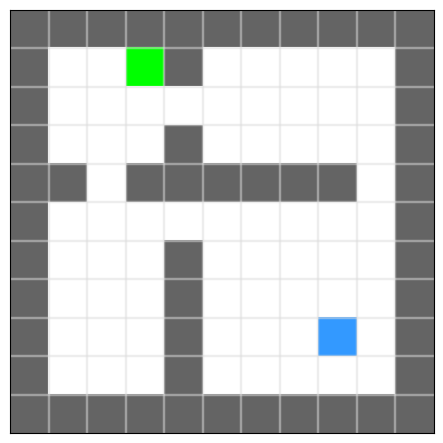

In [2]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts'))
test.reset()
test.render(return_img=False) 

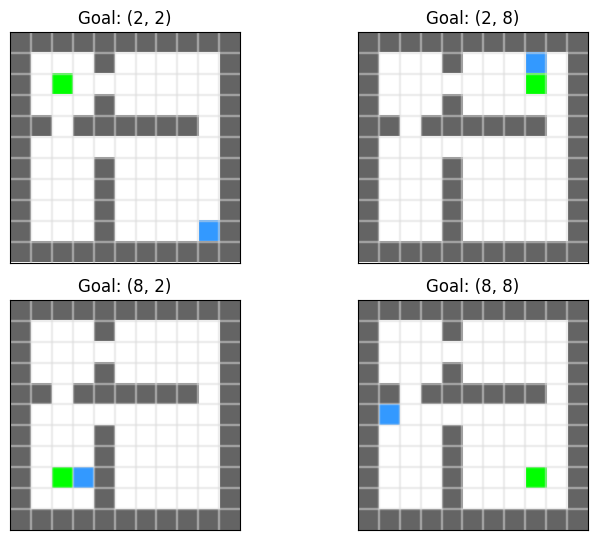

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

In [4]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze())
test.reset()
img = test.render(return_img=True) 

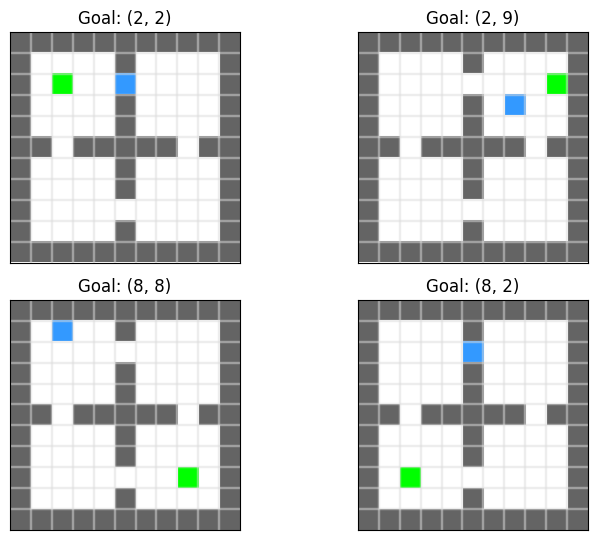

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

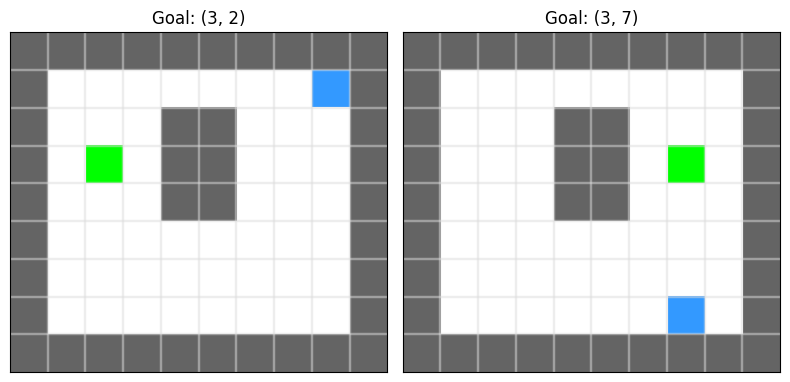

In [6]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(maze_type="gridworld"))
test.reset()

fig, ax = plt.subplots(nrows=1, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

# Data Collection

  0%|          | 0/1 [00:00<?, ?it/s]

{
│   'actions': (200000,),
│   'layout_type': (200000, 1),
│   'next_observations': (200000, 2),
│   'observations': (200000, 2),
│   'terminals': (200000,)
}

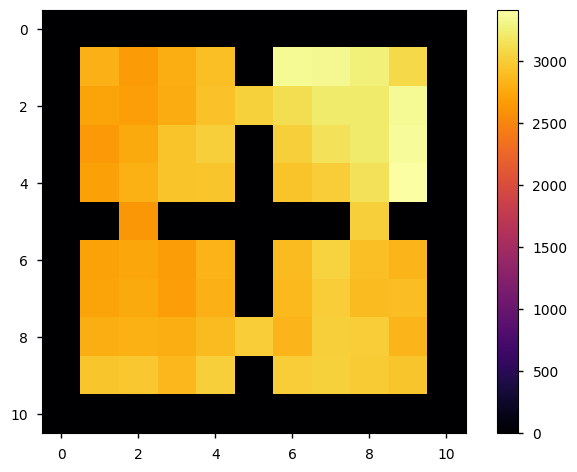

In [7]:
from envs.minigrid.env_utils import random_exploration_fourrooms, q_learning

train_layout_data = []
NUM_TRAIN_LAYOUTS = 1
NUM_TRAIN_STEPS = 100
NUM_TRAIN_EPISODES = 2000

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = FourRoomsMazeEnv(Maze(), max_steps=NUM_TRAIN_STEPS)
    dataset, env = random_exploration_fourrooms(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
    #dataset, env = q_learning(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, epsilon=0.75, num_mdp=NUM_TRAIN_LAYOUTS)
    train_layout_data.append(dataset)
    
pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=env.maze.size)
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

In [8]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# np.save(f"../aux_data/iql_door_data_meta", arr=jax.device_get(whole_data))
# whole_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/iql_door_data_meta.npy", allow_pickle=True).item()
print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 200000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [512, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'number_of_meta_envs': 5,
│   │   'use_context': True,
│   │   'warmup_steps': 50000,
│   │   'n_blocks': 4,
│   │   'n_heads': 4,
│   │   'emb_dim': 72,
│   │   'mlp_dim': 256,
│   │   'output_dim': 4,
│   │   'context_len': 100,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False
│   },
│   'env': {'env_name': 'gridworld', 'discrete': True},
│   'tags': ['fb', 'discrete']
}

{'actions': (200000,), 'layout_type': (200000, 1), 'next_observations': (200000, 2), 'observations': (200000, 2), 'terminals': (200000,)}


In [9]:
sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

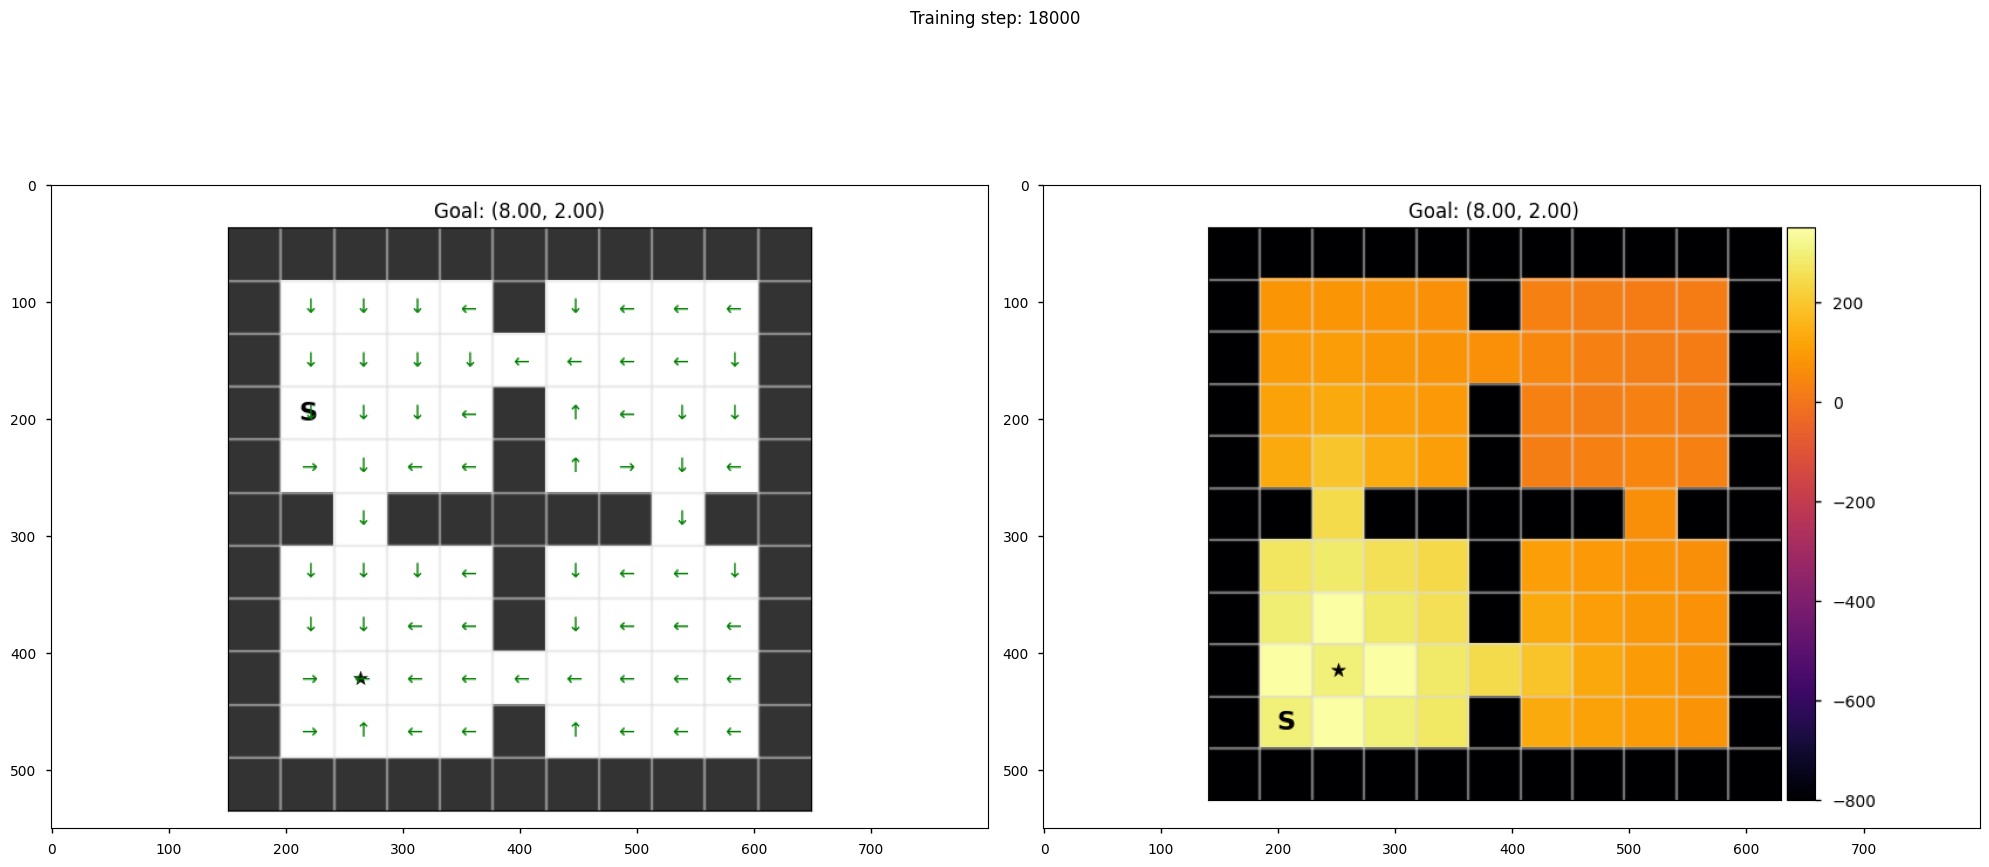

In [12]:
from envs.custom_mazes.env_utils import policy_image_fourrooms, value_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng
from IPython.display import clear_output

def visualize_value_image(task_num):
    env = FourRoomsMazeEnv(Maze())
    env.reset()
    observation, info = env.setup_goals(seed=None, task_num=task_num)
    goal = info.get("goal_pos", None)
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    N, M = env.maze.size
    pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                                value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
    return pred_value_img

def visualize_policy(task_num):
    env = FourRoomsMazeEnv(Maze())
    env.reset()
    observation, info = env.setup_goals(seed=None, task_num=task_num)
    goal = info.get("goal_pos", None)
    latent_z = fb_agent.infer_z(goal)
    start = info.get("start_pos", None)
    example_batch = whole_dataset.sample(1)
    pred_policy_img = policy_image_fourrooms(env, example_batch, N=env.maze.size[0], M=env.maze.size[1],
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                    goal=goal, start=start)
    return pred_policy_img

pbar = tqdm(range(20_000))
# with jax.disable_jit():
for update_step in pbar:
    batch = gc_whole_dataset.sample(1024)
    fb_agent, info = fb_agent.update(batch)
    if update_step % 2000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        pred_policy_img = visualize_policy(task_num=update_step % 3)
        ax[0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(task_num=update_step % 3)
        ax[1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)
        

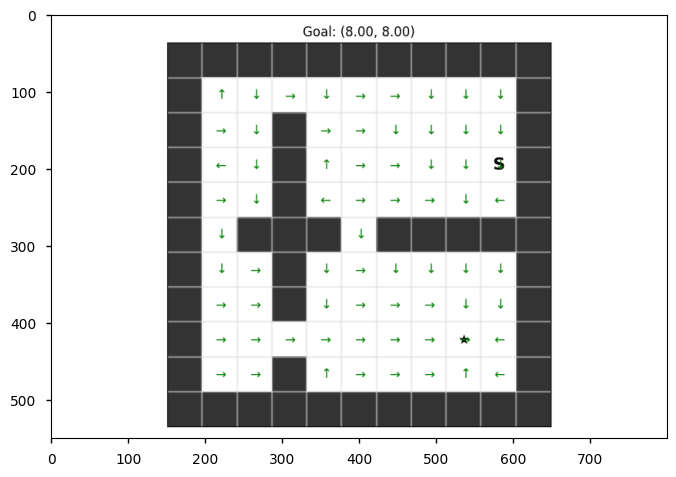

In [11]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
env.reset() # for testing FB on new layout

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = fb_agent.infer_z(goal)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
pred_policy_img = policy_image_fourrooms(env, example_batch, N=11, M=11,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

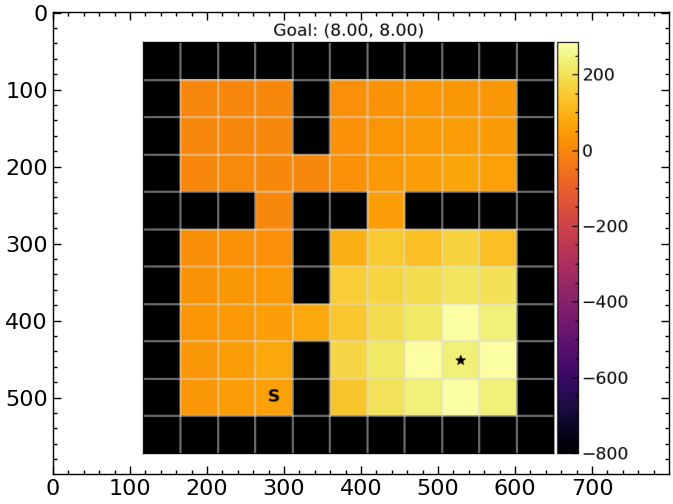

In [ ]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = env.maze.size
pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
plt.imshow(pred_value_img)

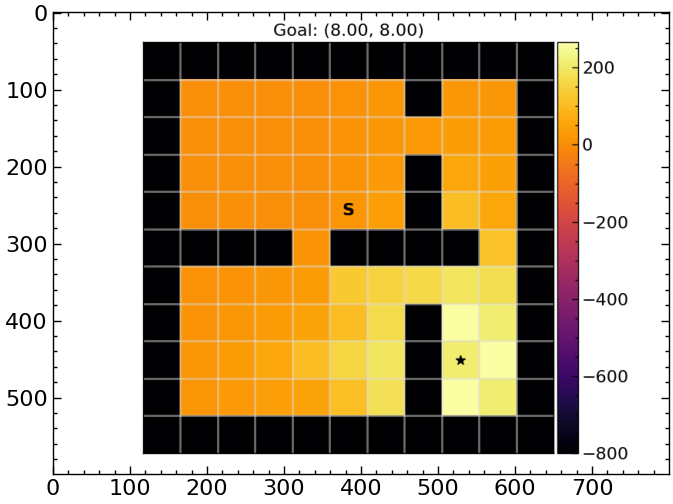

In [ ]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
env.reset() # for testing FB on new layout

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = env.maze.size
pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
plt.imshow(pred_value_img)